# CODEATHON 2: Recognizing UVA landmarks with neural nets (50 pts)
![UVA Grounds](http://faculty.virginia.edu/lazzara/images/UVAgrounds.jpg) 

The UVA Grounds is known for its Jeffersonian architecture and place in U.S. history as a model for college and university campuses throughout the country. Throughout its history, the University of Virginia has won praises for its unique Jeffersonian architecture. 

In this codeathon, you will attempt the build an image recognition system to classify different buildlings/landmarks on Grounds. You will earn 50 points for this codeathon plus 10 bonus points if (1) your classifier performs exceed 95% accuracy OR you try at least 3 different architectures and able to analyze their performance.

To make it easier for you, some codes have been provided to help you process the data, you may modify it to fit your needs. You must submit the .ipynb file via UVA Collab with the following format: yourcomputingID_codeathon_2.ipynb

Best of luck, and have fun! 

# Load Packages

In [2]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

np.random.seed(49)
tf.random.set_seed(49)

# Import Dataset
The full dataset is huge (+37GB) with +13K images of 18 classes. So it will take a while to download, extract, and process. To save you time and effort, a subset of the data has been resized and compressed to only 379Mb and stored in my Firebase server. This dataset will be the one you will benchmark for your grade. If you are up for a challenge (and perhaps bonus points), contact the instructor for the full dataset!

In [3]:
# Download dataset from Firebase
!wget https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media&token=e1403951-30d6-42b8-ba4e-394af1a2ddb7

--2020-11-05 02:34:19--  https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media
Resolving firebasestorage.googleapis.com (firebasestorage.googleapis.com)... 172.217.13.234, 2607:f8b0:4004:80a::200a
Connecting to firebasestorage.googleapis.com (firebasestorage.googleapis.com)|172.217.13.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 397174132 (379M) [application/zip]
Saving to: ‘dataset.zip?alt=media’

dataset.zip?alt=med 100%[===================>] 378.77M   168MB/s    in 2.3s    

2020-11-05 02:34:22 (168 MB/s) - ‘dataset.zip?alt=media’ saved [397174132/397174132]



In [4]:
# Extract content
!unzip "/content/dataset.zip?alt=media"

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/dataset/Rotunda/._0000010694.jpg  
  inflating: dataset/Rotunda/0000010680.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010680.jpg  
  inflating: dataset/Rotunda/0000010858.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010858.jpg  
  inflating: dataset/Rotunda/0000010870.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010870.jpg  
  inflating: dataset/Rotunda/0000010864.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010864.jpg  
  inflating: dataset/Rotunda/0000010865.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010865.jpg  
  inflating: dataset/Rotunda/0000010871.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010871.jpg  
  inflating: dataset/Rotunda/0000010859.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010859.jpg  
  inflating: dataset/Rotunda/0000010681.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010681.jpg  
  inflating: dataset/Rotunda/0000010695.jpg  
  inflating: __MACOSX/

In [5]:
from sklearn.datasets import load_files 
from keras.utils import np_utils

from keras.preprocessing import image
from tqdm import tqdm # progress bar

data_dir = "/content/dataset/"
batch_size = 64;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
# for relnet50
# img_height = 224; 
# img_width = 224;
# for Xception
img_height = 299; 
img_width = 299;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 49,
    image_size= (img_height, img_width),
    batch_size = batch_size,
    #color_mode= 'grayscale'
)

# Test Dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 49,
    image_size = (img_height, img_width),
    batch_size = batch_size,
    #color_mode='grayscale'

)        

Found 14286 files belonging to 18 classes.
Using 11429 files for training.
Found 14286 files belonging to 18 classes.
Using 2857 files for validation.


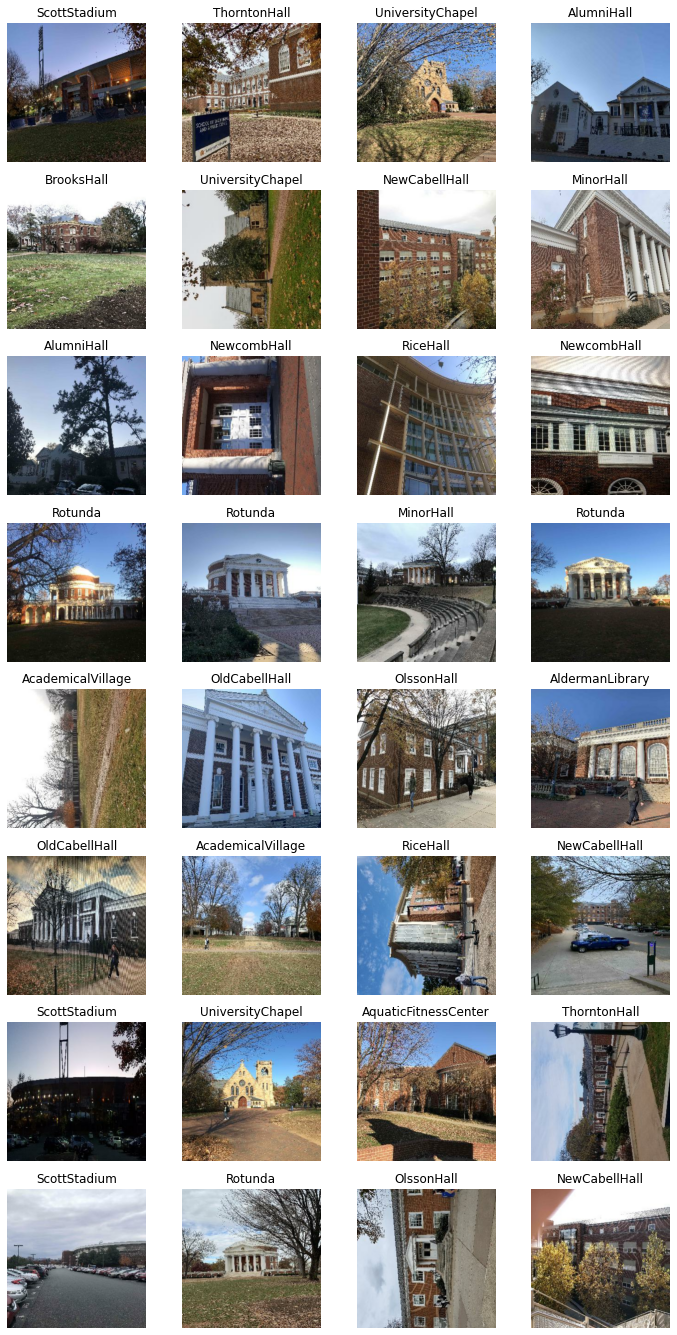

In [6]:
# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['AcademicalVillage', 'AldermanLibrary', 'AlumniHall', 'AquaticFitnessCenter', 
  'BavaroHall', 'BrooksHall', 'ClarkHall', 'MadisonHall', 'MinorHall', 'NewCabellHall', 
  'NewcombHall', 'OldCabellHall', 'OlssonHall', 'RiceHall', 'Rotunda', 'ScottStadium', 
  'ThorntonHall', 'UniversityChapel']

# Rows and columns are set to fit one training batch (32)
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)


# It's your turn: Building a classifier for UVA Landmark Dataset
You may design your own architecture OR re-use any of the exising frameworks. 

Best of luck!

In [8]:
base = keras.applications.ResNet50(weights = 'imagenet',include_top=False)
for layer in base.layers:
  layer.trainable = False
model2 = keras.models.Sequential([
  base,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.BatchNormalization(),
  keras.layers.Dense(units=64, activation='relu'),
  keras.layers.Dropout(0.25),
  keras.layers.Dense(units=18, activation='softmax')
])
optimizer = keras.optimizers.SGD(lr = .2, momentum = .9, decay = .01, nesterov=True)
model2.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
history = model2.fit(train_ds, validation_data = test_ds, epochs = 10)

Epoch 1/10
179/179 [==============================] - 112s 628ms/step - loss: 1.3204 - accuracy: 0.6288 - val_loss: 0.8474 - val_accuracy: 0.8057
Epoch 2/10
179/179 [==============================] - 112s 626ms/step - loss: 0.6165 - accuracy: 0.8253 - val_loss: 0.5447 - val_accuracy: 0.8631
Epoch 3/10
179/179 [==============================] - 112s 626ms/step - loss: 0.4315 - accuracy: 0.8751 - val_loss: 0.4830 - val_accuracy: 0.8733
Epoch 4/10
179/179 [==============================] - 112s 624ms/step - loss: 0.3375 - accuracy: 0.9017 - val_loss: 0.4660 - val_accuracy: 0.8859
Epoch 5/10
179/179 [==============================] - 112s 625ms/step - loss: 0.2664 - accuracy: 0.9227 - val_loss: 0.4584 - val_accuracy: 0.8894
Epoch 6/10
179/179 [==============================] - 112s 624ms/step - loss: 0.2146 - accuracy: 0.9374 - val_loss: 0.4569 - val_accuracy: 0.8957
Epoch 7/10
179/179 [==============================] - 112s 625ms/step - loss: 0.1914 - accuracy: 0.9416 - val_loss: 0.4426 -

In [10]:
model2.evaluate(test_ds)

45/45 [==============================] - 21s 467ms/step - loss: 0.4660 - accuracy: 0.8981


[0.466016948223114, 0.8981449007987976]

Using transfer learning from Keras's ResNet50, the model was able to get 89.81% accuracy on the validation set. 

In [8]:
base = keras.applications.ResNet50(weights = 'imagenet',include_top=False)
for layer in base.layers:
  layer.trainable = False
model3 = keras.models.Sequential([
  base,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.BatchNormalization(),
  keras.layers.Dense(units=128, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(units=18, activation='softmax')
])
model3.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'nadam', metrics = ['accuracy'])
history = model3.fit(train_ds, validation_data = test_ds, epochs = 10)



Epoch 1/10
179/179 [==============================] - 106s 592ms/step - loss: 1.4946 - accuracy: 0.5843 - val_loss: 0.8164 - val_accuracy: 0.8054
Epoch 2/10
179/179 [==============================] - 106s 590ms/step - loss: 0.7317 - accuracy: 0.7911 - val_loss: 0.5482 - val_accuracy: 0.8649
Epoch 3/10
179/179 [==============================] - 105s 588ms/step - loss: 0.5460 - accuracy: 0.8392 - val_loss: 0.4755 - val_accuracy: 0.8834
Epoch 4/10
179/179 [==============================] - 106s 592ms/step - loss: 0.4416 - accuracy: 0.8686 - val_loss: 0.4419 - val_accuracy: 0.8925
Epoch 5/10
179/179 [==============================] - 106s 591ms/step - loss: 0.3611 - accuracy: 0.8916 - val_loss: 0.4433 - val_accuracy: 0.8939
Epoch 6/10
179/179 [==============================] - 106s 590ms/step - loss: 0.3107 - accuracy: 0.9021 - val_loss: 0.4264 - val_accuracy: 0.8971
Epoch 7/10
179/179 [==============================] - 106s 591ms/step - loss: 0.2797 - accuracy: 0.9115 - val_loss: 0.4197 -

In [6]:
# # YOUR CODE STARTS HERE
# DefaultConv2D = partial(keras.layers.Conv2D, 
#                         kernel_size = 3, activation='relu', padding='SAME')

# model = keras.models.Sequential([
#     DefaultConv2D(filters=64,kernel_size = 7, input_shape = [256,256,3]),
#     keras.layers.MaxPooling2D(pool_size=2),
#     DefaultConv2D(filters=64),
#     keras.layers.MaxPooling2D(pool_size=2),
#     #DefaultConv2D(filters=64),
#     DefaultConv2D(filters=64),
#     keras.layers.MaxPooling2D(pool_size=2),
#     DefaultConv2D(filters=64),
#     DefaultConv2D(filters=64),
#     keras.layers.MaxPooling2D(pool_size=2),
#     DefaultConv2D(filters=64),
#     DefaultConv2D(filters=64),
#     keras.layers.MaxPooling2D(pool_size=2),
#     DefaultConv2D(filters=64),
#     DefaultConv2D(filters=64),
#     keras.layers.MaxPooling2D(pool_size=2),
#     DefaultConv2D(filters=64),
#     DefaultConv2D(filters=64),
#     keras.layers.MaxPooling2D(pool_size=2),
#     DefaultConv2D(filters=64),
#     DefaultConv2D(filters=64),
#     keras.layers.MaxPooling2D(pool_size=2),
#     keras.layers.Flatten(),
#     keras.layers.Dense(units=64, activation='relu'),
#     keras.layers.Dropout(0.25),
#     keras.layers.Dense(units=64, activation='relu'),
#     keras.layers.Dropout(0.25),
#     keras.layers.Dense(units=18, activation='softmax'),     
#     #75% 22 epoch                       
#     # DefaultConv2D(filters=64,kernel_size = 7, input_shape = [150,150,3]),
#     # keras.layers.MaxPooling2D(pool_size=2),
#     # DefaultConv2D(filters=64),
#     # DefaultConv2D(filters=64),
#     # keras.layers.MaxPooling2D(pool_size=2),
#     # DefaultConv2D(filters=64),
#     # DefaultConv2D(filters=64),
#     # keras.layers.MaxPooling2D(pool_size=2),
#     # DefaultConv2D(filters=128),
#     # DefaultConv2D(filters=128),
#     # keras.layers.MaxPooling2D(pool_size=2),
#     # DefaultConv2D(filters=128),
#     # DefaultConv2D(filters=128),
#     # keras.layers.MaxPooling2D(pool_size=2),
#     # keras.layers.Flatten(),
#     # keras.layers.Dense(units=128, activation='relu'),
#     # keras.layers.Dropout(0.25),
#     # keras.layers.Dense(units=64, activation='relu'),
#     # keras.layers.Dropout(0.25),
#     # keras.layers.Dense(units=18, activation='softmax'),
                         
# ])

In [ ]:
# model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# history = model.fit(train_ds, epochs=80, validation_data = test_ds)